In [ ]:
from google.colab import drive
drive.mount('/content/drive')#4/ZQEnezd34cig6P2jUx_U7x6ZBdOBGsCQJeF2Q2_9dPkjeCvjqmy2hIc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Todos los modelos

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.2


In [3]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jgonzalez/Anaconda/Ternadus/chest_xray/chest_xray'
#data_dir = 'drive/My Drive/Colab Notebooks/chest_xray'
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

### Train

In [4]:
def train_model(model, dataloaders, criterion, sheduler, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        scheduler.step()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Test

In [5]:

def test_model(model, dataloaders, criterion):
    since = time.time()
    test_acc_history = []

    for epoch in range(1):
        print('Epoch {}/{}'.format(epoch, 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['test']:
            model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # track history if only in train
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
     
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            
            test_acc_history.append(epoch_acc)

            print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
   



### Visualize

In [6]:
def visualize_model(model,dataloaders):
    # obtain one batch of test images
    dataiter = iter(dataloaders['test'])
    images, labels = dataiter.next()

    # move model inputs to cuda, if GPU available
    images = images.to(device)

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds= torch.max(output, 1)
    preds=np.squeeze(preds.to('cpu').numpy())

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(16):
        ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
        inp = images[idx].to('cpu').numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        #plt.imshow(((images[idx]//2).to('cpu').numpy().transpose(1,2,0)))
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
        color=("green" if preds[idx]==labels[idx].item() else "red"))
        



### Initialize_model

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        print("resnet18...")
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        fc = nn.Sequential(
        nn.Linear(num_ftrs, 240),
        nn.ReLU(),
        nn.Dropout(0.25),    
        nn.Linear(240,num_classes))        
        
        model_ft.fc = fc
        input_size = 224
        print("resnet50...")
    
    elif model_name == "vgg11":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        print("vgg11_bn...")
    
    elif model_name == "densenet121":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        print("densenet...")
    elif model_name == "densenet201":
        """ Densenet
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        
        num_ftrs = model_ft.classifier.in_features
        fc = nn.Sequential(
        nn.Linear(num_ftrs, 240),
        nn.ReLU(),
        nn.Dropout(0.25),    
        nn.Linear(240,num_classes))        
        
        model_ft.classifier = fc
        input_size = 224
        print("densenett201.") 
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        print("inception")
    else:
        print("Invalid model name, exiting...")
        exit()

    params_to_update = model_ft.parameters()
    

    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
    """"            #print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
     """     
    return model_ft, input_size, params_to_update


# Initialize the model for this run
#model_ft, input_size = initialize_model('resnet', num_classes, feature_extract=False, use_pretrained=True)


### Data

In [9]:
input_size = 224

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
   'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val','test']}  #uso test no val
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val','test']} #uso test no val

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if not 'cuda':
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
print(len(image_datasets['train']))
print(len(image_datasets['val']))
print(len(image_datasets['test']))

class_names = image_datasets['train'].classes
print(class_names)

print(len(dataloaders_dict['train']))
print(len(dataloaders_dict['val']))
print(len(dataloaders_dict['test']))

Initializing Datasets and Dataloaders...
CUDA is available!  Training on GPU ...
5216
16
624
['NORMAL', 'PNEUMONIA']
163
1
20


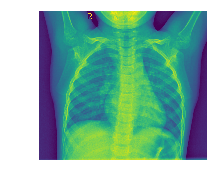

In [40]:
#img_dir='drive/My Drive/Colab Notebooks/chest_xray'
img_dir='/home/jgonzalez/Anaconda/Ternadus/chest_xray/chest_xray'
def imshow(image):
    """Display image"""
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
# Example image
x = Image.open(img_dir + '/train/NORMAL/IM-0115-0001.jpeg')
np.array(x).shape
imshow(x)

## Definir el modelo

# Resnet 18

In [25]:
model_name='resnet18'
model_resnet, input_size,params_to_update = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
# Send the model to GPU
model_resnet = model_resnet.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.003, momentum=0.9)#
#optimizer_ft = optim.Adam(params_to_update, lr=0.003)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1) #cada 7 pasos reduzco en 0.1
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


resnet18...
Params to learn:


In [26]:
# Train and evaluate
model_resnet, hist = train_model(model_resnet, dataloaders_dict, criterion,scheduler, optimizer_ft, num_epochs=24, is_inception=(model_name=="inception"))

Epoch 0/23
----------
train Loss: 0.2443 Acc: 0.8967
val Loss: 2.4211 Acc: 0.5625

Epoch 1/23
----------
train Loss: 0.1873 Acc: 0.9291
val Loss: 0.5305 Acc: 0.7500

Epoch 2/23
----------
train Loss: 0.1626 Acc: 0.9388
val Loss: 0.7987 Acc: 0.6250

Epoch 3/23
----------
train Loss: 0.1643 Acc: 0.9379
val Loss: 0.1696 Acc: 0.9375

Epoch 4/23
----------
train Loss: 0.1441 Acc: 0.9465
val Loss: 0.3921 Acc: 0.6875

Epoch 5/23
----------
train Loss: 0.1248 Acc: 0.9548
val Loss: 0.2128 Acc: 0.8750

Epoch 6/23
----------
train Loss: 0.1076 Acc: 0.9603
val Loss: 0.1657 Acc: 0.8750

Epoch 7/23
----------
train Loss: 0.1057 Acc: 0.9611
val Loss: 0.0694 Acc: 1.0000

Epoch 8/23
----------
train Loss: 0.1092 Acc: 0.9609
val Loss: 0.1331 Acc: 1.0000

Epoch 9/23
----------
train Loss: 0.0994 Acc: 0.9640
val Loss: 0.0840 Acc: 1.0000

Epoch 10/23
----------
train Loss: 0.0954 Acc: 0.9641
val Loss: 0.0793 Acc: 1.0000

Epoch 11/23
----------
train Loss: 0.1006 Acc: 0.9601
val Loss: 0.0617 Acc: 1.0000

Ep

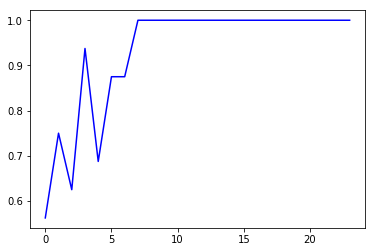

In [27]:
    plt.figure()
    plt.plot(hist, color='blue')
    plt.show()

####Save

In [30]:
torch.save(model_resnet.state_dict(),'modelResnet189471.pth') 


###Load



In [41]:
model_ft.load_state_dict(torch.load('model2Resnet18.pth')) #primero tuve q cagar el pretrained


Epoch 0/1
----------
test Loss: 0.1426 Acc: 0.9471

Training complete in 0m 3s


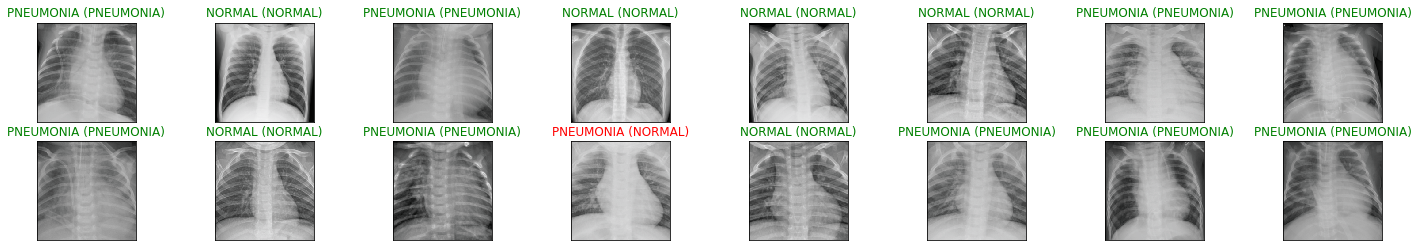

In [28]:

visualize_model(model_resnet,dataloaders_dict)
test_model(model_resnet,dataloaders_dict,criterion)

Freezing: vgg= 0.87
densenet=0.87
resnet 0.875
FineTuning: 
vgg 0.94  ----14
densenet 0.953
resnet 0.95

# Resnet 50

In [22]:
model_name = "resnet50"
model_resnet50, input_size,params_to_update = initialize_model(model_name, num_classes=2, feature_extract=False, use_pretrained=True)

model_resnet50 = model_resnet50.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.003, momentum=0.9)#
#optimizer_ft = optim.Adam(params_to_update, lr=0.003)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1) #cada 7 pasos reduzco en 0.1
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_resnet, hist = train_model(model_resnet50, dataloaders_dict, criterion,scheduler, optimizer_ft, num_epochs=24, is_inception=(model_name=="inception"))

resnet50...
Params to learn:
Epoch 0/23
----------
train Loss: 0.2740 Acc: 0.8800
val Loss: 0.5027 Acc: 0.7500

Epoch 1/23
----------
train Loss: 0.1696 Acc: 0.9333
val Loss: 0.2405 Acc: 0.8750

Epoch 2/23
----------
train Loss: 0.1522 Acc: 0.9402
val Loss: 0.1273 Acc: 1.0000

Epoch 3/23
----------
train Loss: 0.1386 Acc: 0.9511
val Loss: 0.1277 Acc: 0.9375

Epoch 4/23
----------
train Loss: 0.1217 Acc: 0.9521
val Loss: 0.1074 Acc: 0.9375

Epoch 5/23
----------
train Loss: 0.1084 Acc: 0.9594
val Loss: 0.0559 Acc: 1.0000

Epoch 6/23
----------
train Loss: 0.0962 Acc: 0.9645
val Loss: 0.0479 Acc: 1.0000

Epoch 7/23
----------
train Loss: 0.0948 Acc: 0.9666
val Loss: 0.0541 Acc: 1.0000

Epoch 8/23
----------
train Loss: 0.0888 Acc: 0.9672
val Loss: 0.0549 Acc: 1.0000

Epoch 9/23
----------
train Loss: 0.0896 Acc: 0.9640
val Loss: 0.0904 Acc: 0.9375

Epoch 10/23
----------
train Loss: 0.0887 Acc: 0.9664
val Loss: 0.0483 Acc: 1.0000

Epoch 11/23
----------
train Loss: 0.0876 Acc: 0.9666
val

Epoch 0/1
----------
test Loss: 0.1197 Acc: 0.9615

Training complete in 0m 3s


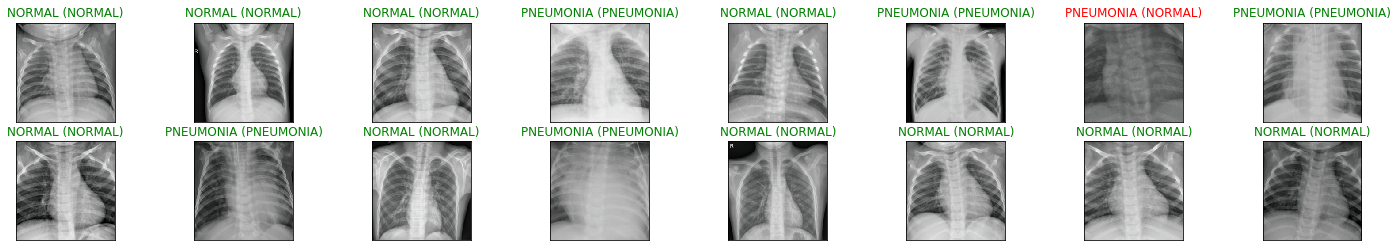

In [24]:
torch.save(model_resnet50.state_dict(),'modelResnet50SGD59615.pth') #guardar una red neuronal y el optimizador en el archivo pth

visualize_model(model_resnet50,dataloaders_dict)
test_model(model_resnet50,dataloaders_dict,criterion)

In [23]:
test_model(model_resnet50,dataloaders_dict,criterion)

Epoch 0/1
----------
test Loss: 0.1197 Acc: 0.9615

Training complete in 0m 3s


# Densenet

In [15]:
model_name = "densenet201"
model_densenet, input_size,params_to_update  = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
model_densenet = model_densenet.to(device)
#model_densenet_optimizer = optim.SGD(model_densenet.parameters(), lr=0.001, momentum=0.9)
model_densenet_optimizer = optim.Adagrad(model_densenet.parameters(), lr=0.003)
scheduler= torch.optim.lr_scheduler.StepLR(model_densenet_optimizer, step_size=7, gamma=0.1) #cada 7 pasos reduzco en 0.1
model_densenet_criterion = nn.CrossEntropyLoss()
model_densenet, hist = train_model(model_densenet, dataloaders_dict, model_densenet_criterion,scheduler, model_densenet_optimizer, num_epochs=15, is_inception=(model_name=="inception"))


densenett201.
Params to learn:
Epoch 0/14
----------
train Loss: 0.2888 Acc: 0.8852
val Loss: 1.1403 Acc: 0.6250

Epoch 1/14
----------
train Loss: 0.1871 Acc: 0.9273
val Loss: 0.2535 Acc: 0.8750

Epoch 2/14
----------
train Loss: 0.1616 Acc: 0.9358
val Loss: 0.5821 Acc: 0.6875

Epoch 3/14
----------
train Loss: 0.1419 Acc: 0.9465
val Loss: 0.5250 Acc: 0.6875

Epoch 4/14
----------
train Loss: 0.1253 Acc: 0.9530
val Loss: 0.0957 Acc: 1.0000

Epoch 5/14
----------
train Loss: 0.1201 Acc: 0.9578
val Loss: 0.4416 Acc: 0.6875

Epoch 6/14
----------
train Loss: 0.1209 Acc: 0.9559
val Loss: 0.1998 Acc: 0.9375

Epoch 7/14
----------
train Loss: 0.0931 Acc: 0.9645
val Loss: 0.1782 Acc: 0.9375

Epoch 8/14
----------
train Loss: 0.0854 Acc: 0.9684
val Loss: 0.1515 Acc: 0.9375

Epoch 9/14
----------
train Loss: 0.0816 Acc: 0.9737
val Loss: 0.1175 Acc: 1.0000

Epoch 10/14
----------
train Loss: 0.0822 Acc: 0.9701
val Loss: 0.1448 Acc: 0.9375

Epoch 11/14
----------
train Loss: 0.0824 Acc: 0.9709
v

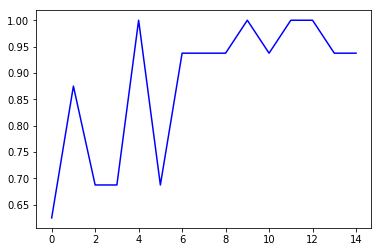

In [18]:
plt.figure()
plt.plot(hist, color='blue')
plt.show()

In [57]:
torch.save(model_densenet.state_dict(),'Densenet201-9647.pth') #guardar una red neuronal y el optimizador en el archivo pth


In [11]:
model_name = "densenet201"
model_densenet,input_size,params_to_update  = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
model_densenet.to(device)
model_densenet_criterion = nn.CrossEntropyLoss()

model_densenet.load_state_dict(torch.load('Densenet201-9647.pth')) #primero tuve q cagar el pretrained


densenett201.
Params to learn:


In [12]:
test_model(model_densenet,dataloaders_dict,model_densenet_criterion)

Epoch 0/1
----------
test Loss: 0.1246 Acc: 0.9647

Training complete in 0m 5s


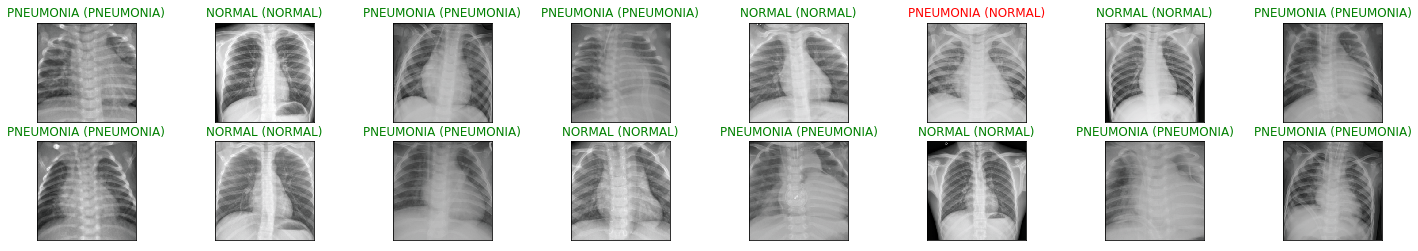

In [28]:
visualize_model(model_densenet,dataloaders_dict)


# Inception

In [31]:
# Setup the loss fxn
model_name = "inception"
model_inception, input_size, params_to_update = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
params_to_update

inception
Params to learn:


<generator object Module.parameters at 0x7f5d00c85f10>

In [32]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
   'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val','test']}  #uso test no val
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val','test']} #uso test no val

# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if not 'cuda':
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
print(len(image_datasets['train']))
print(len(image_datasets['val']))
print(len(image_datasets['test']))

class_names = image_datasets['train'].classes

print(class_names)

Initializing Datasets and Dataloaders...
CUDA is available!  Training on GPU ...
5216
16
624
['NORMAL', 'PNEUMONIA']


In [33]:

model_inception= model_inception.to(device)
optimizer_in = optim.SGD(model_inception.parameters(), lr=0.003, momentum=0.9)
scheduler_in= torch.optim.lr_scheduler.StepLR(optimizer_in, step_size=5, gamma=0.1) #cada 7 pasos reduzco en 0.1
criterion_in = nn.CrossEntropyLoss()

# Train and evaluate
model_inception, hist_inception = train_model(model_inception, dataloaders_dict, criterion_in ,scheduler_in, optimizer_in, num_epochs=24, is_inception=(model_name=="inception"))

Epoch 0/23
----------
train Loss: 0.3665 Acc: 0.8846
val Loss: 0.2668 Acc: 0.9375

Epoch 1/23
----------
train Loss: 0.2245 Acc: 0.9377
val Loss: 0.4905 Acc: 0.6875

Epoch 2/23
----------
train Loss: 0.1980 Acc: 0.9456
val Loss: 1.5359 Acc: 0.5000

Epoch 3/23
----------
train Loss: 0.1945 Acc: 0.9465
val Loss: 0.5774 Acc: 0.6875

Epoch 4/23
----------
train Loss: 0.1688 Acc: 0.9584
val Loss: 0.4308 Acc: 0.7500

Epoch 5/23
----------
train Loss: 0.1567 Acc: 0.9576
val Loss: 0.2095 Acc: 0.9375

Epoch 6/23
----------
train Loss: 0.1468 Acc: 0.9603
val Loss: 0.2811 Acc: 0.8750

Epoch 7/23
----------
train Loss: 0.1270 Acc: 0.9657
val Loss: 0.1503 Acc: 0.9375

Epoch 8/23
----------
train Loss: 0.1198 Acc: 0.9697
val Loss: 0.1178 Acc: 1.0000

Epoch 9/23
----------
train Loss: 0.1232 Acc: 0.9703
val Loss: 0.1822 Acc: 0.8750

Epoch 10/23
----------
train Loss: 0.1098 Acc: 0.9712
val Loss: 0.1672 Acc: 1.0000

Epoch 11/23
----------
train Loss: 0.1043 Acc: 0.9739
val Loss: 0.0767 Acc: 1.0000

Ep

In [ ]:
model_name = "Inception"
model_incep, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)

model_incep.load_state_dict(torch.load('modelInception.pth')) #primero tuve q cagar el pretrained
model_incep.to(device)
visualize_model(model_incep,dataloaders_dict)


In [34]:
torch.save(model_inception.state_dict(),'modelInception.pth') #guardar una red neuronal y el optimizador en el archivo pth


In [37]:
test_model(model_inception,dataloaders_dict,criterion_in)

Epoch 0/1
----------
test Loss: 0.0964 Acc: 0.9599

Training complete in 0m 3s


# GrandCAM

In [ ]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

(1192, 952)


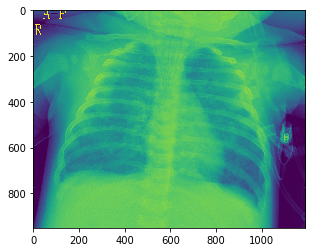

In [ ]:
image = Image.open(img_dir + '/test/PNEUMONIA/person1952_bacteria_4883.jpeg')
imshow(image)
print(np.size(image))

In [ ]:
img, _ = next(iter(dataloaders_dict['test']))

tensor = img[0]


In [ ]:
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
np.shape(prediction_var)

torch.Size([1, 3, 224, 224])

In [ ]:
model=model_resnet

In [ ]:
model.cuda()
model.eval()

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [ ]:
final_layer = model._modules.get('layer4')

activated_features = SaveFeatures(final_layer)
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [ ]:
topk(pred_probabilities,1)



torch.return_types.topk(values=tensor([0.9941], device='cuda:0'), indices=tensor([1], device='cuda:0'))

In [ ]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [ ]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())


In [ ]:
weight_softmax_params


In [ ]:
class_idx = topk(pred_probabilities,1)[1].int()


In [ ]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )


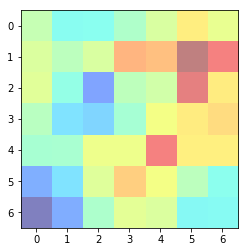

In [ ]:
imshow(overlay[0], alpha=0.5, cmap='jet')


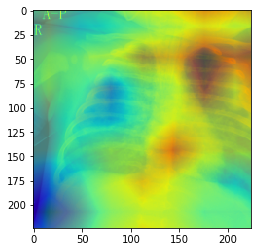

In [ ]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');